# Hypothesis testing

The beginning of modern statistics is credited to Ronald Fisher in the early 20th century, who established and popularized the idea of testing observed differences for statistical significance to determine if the differences were likely/unlikely to be due to random chance

![hypothesis_tea_1.png](images/hypothesis_tea_1.png)

The story of how the idea of significance testing began in the 1920's, when Dr Fisher worked at an agricultural research institute to help scientists design better experiments. 
- At an afternoon tea, Fisher made a cup of tea for Dr Muriel Bristol
- She refused the cup of tea because she said Fisher had poured the milk into the cup first before the tea and she preferred tea prepared when milk was added after tea was poured into the cup
- She claimed that she could taste the difference between the 2 preparations 
- Fisher was skeptical and devised an experiment with his colleague, William Roach

To test whether Dr Bristol could taste a difference between the 2 tea preparations, an experiment was designed to see how often she could pick the correct tea preparation from a randomized set
- 4 tea cups of milk into tea (MT) and 4 cups of tea into milk (TM) were prepared
- The 8 cups were randomized and presented to Dr Bristol for tasting to see if she could distinguish MT and TM preparations

![hypothesis_tea_2.png](images/hypothesis_tea_2.png)

Dr Bristol correctly identified the 4 cups of MT and 4 cups of TM preparations
- From all the 70 possible combinations, only 2 of them would be consistent with Dr Bristol being able to distinguish MT and TM preparations
- As the chance is low, it is unlikely that she guessed the order correctly and consistent with her claim that she was able to taste the difference between the tea preparations

The ideas behind this experiment formed the basis for statistical testing to determine if an observed difference is likely/unlikely to be due to chance. 
- `Null hypothesis`: what would data look like if there were no differences to begin with?
- `Significance testing`: what is the probability of obtaining results as least as extreme as the observed results of a test, assuming there is no difference (null hypothesis)?

For more details about the story, see: 
https://www.sciencehistory.org/distillations/ronald-fisher-a-bad-cup-of-tea-and-the-birth-of-modern-statistics

---
## Data preparation

To illustrate the ideas behind the null hypothesis and significance testing, we will use a dataset from https://myweb.uiowa.edu/pbreheny/data/oatbran.html
- Cholesterol measurements in people who were put on a diet of cornflakes or oatbran
- For this example, let us assume that these are 2 independent groups of people on the 2 different diets

In [ ]:
library(tidyverse)

data <- read_tsv("https://raw.githubusercontent.com/kennethban/dataset/main/oatbran.tsv")

# convert the data from a wide to long format

data_grouped <- data %>% 
                pivot_longer(c("CornFlakes", "OatBran"), 
                             names_to="treatment", 
                             values_to="effect") %>%
                mutate(treatment=as.factor(treatment))
                
head(data_grouped)
tail(data_grouped)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Rows: 14 Columns: 2

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (2): CornFlakes, OatBran


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



treatment,effect
<fct>,<dbl>
CornFlakes,4.61
OatBran,3.84
CornFlakes,6.42
OatBran,5.57
CornFlakes,5.40
OatBran,5.85


treatment,effect
<fct>,<dbl>
CornFlakes,3.89
OatBran,3.73
CornFlakes,2.25
OatBran,1.84
CornFlakes,4.24
OatBran,4.14


We can visualize the cholesterol measurements in the 2 groups using a boxplot

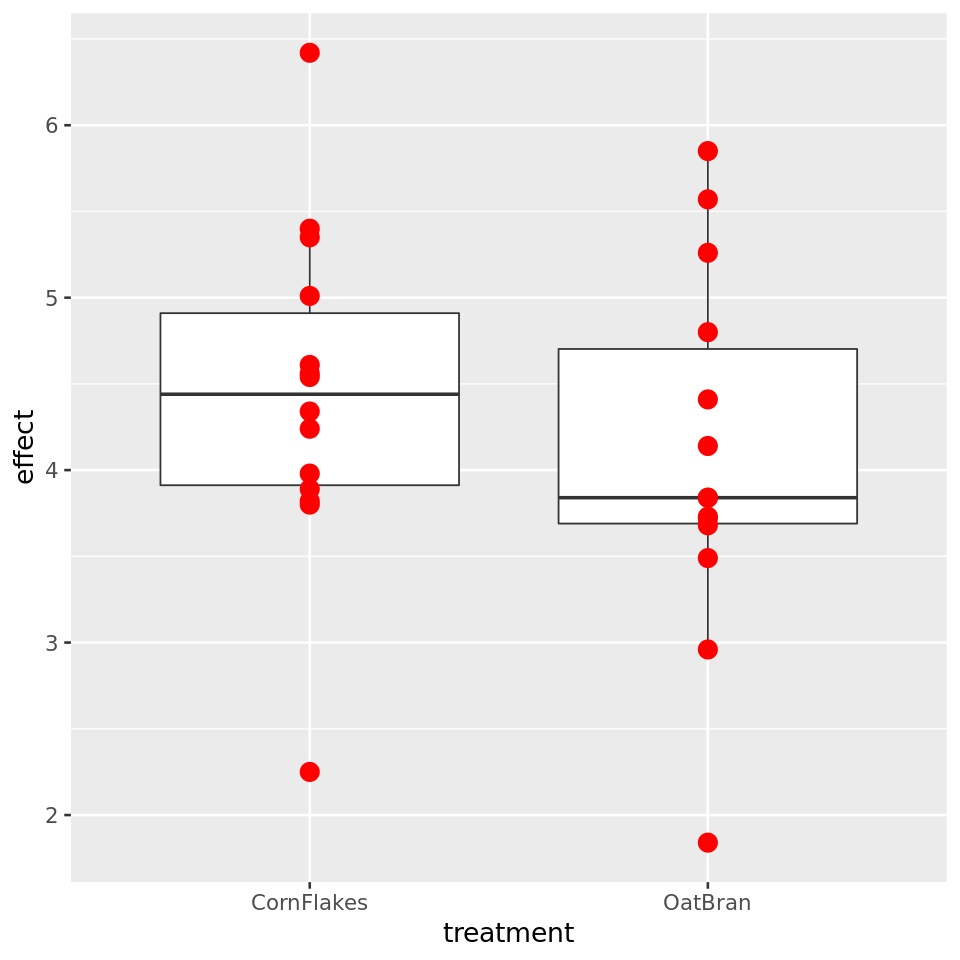

In [ ]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

data_grouped %>% 
ggplot(aes(x=treatment, y=effect)) + 
  geom_boxplot() +
  geom_point(color="red", size=5) + 
  theme_grey(base_size=16)

We observe a difference of cholesterol levels between the 2 diets. 
- How can we quantify the difference?
- How likely is this observed difference due to chance?


---
## Overview of hypothesis testing approaches
There are two major approaches to hypothesis testing and for this course we will be focusing on the **frequentist** approach, which is most commonly used

![hypothesis_approaches.png](images/hypothesis_approaches.png)

In the frequentist approach
- We first make the hypothesis/assumption that there are _no differences_ in the data (null distribution)
- We then find the probability of obtaining the data we observe given a null distribution $P(\text{Data}|\text{Null distribution})$
  - If the probability is low, it suggests that the data we observe is less likely to have come from a null distribution and that the differences we observe may not be due to random chance
  - If the probability is high, it suggests the data we observe is consistent with having come from a null distribution and the difference we observe may be due to random chance
- There are several approaches to calculating this probability (p-value)
  - Parametric (based on family of distributions)
  - Non-parametric rank/sign-based
  - Non-parametric resampling/permutation


To develop an intuition of the null hypothesis and significance testing, we will introduce the resampling approach. This approach is wonderfully summarized in this animated presentation: https://www.jwilber.me/permutationtest/

---
### 1. Resampling approach

To illustrate how we determine if an observed difference in the our data is likely/unlikely due to chance, we will use a resampling approach based on `infer` library is detailed in this wonderful free e-textbook: https://moderndive.com

![moderndive_infer.png](images/moderndive_infer.png)

#### Overview of resampling approach

We will go through an example to illustrate the steps of 
- using a test statistic to quantify differences in a dataset
- generating a null hypothesis dataset from the data using resampling/permutation
- generating a null distribution using the chosen test statistic
- calculating a p-value based on the observed test statistic and the null distribution

![hypothesis_approach_resample.png](images/hypothesis_approach_resample.png)

#### What is the difference between the groups?

We start by choosing a `test statistic` such as the `mean` to compare the difference between groups

```
Diff mean cholesterol = abs(mean cholesterol on OatBran -
                            mean cholesterol on CornFlakes)
```

In [ ]:
obs_diff_means <- data_grouped %>%
                  summarize(mean1 = mean(effect[treatment=="OatBran"]),
                            mean2 = mean(effect[treatment=="CornFlakes"]),
                            diff_means = abs(mean1 - mean2)) %>%
                  pull(diff_means)

obs_diff_means

[1] 0.3628571

We see that that subjects eating Oatbran have a different mean cholesterol level than those eating Cornflakes

#### Is this observed difference real or due to chance?
How do we know if this difference is due to chance rather than being associated with the change in diet? 
- To evaluate this, we need to compare it to a scenario where the the cholesterol values are not different between the 2 groups (null hypothesis)
- To do this, we can **randomly mix (permute)** the cholesterol values between the 2 groups and do this multiple times to generate a _dataset that represents the null hypothesis_ that there is no association of diet with the change in cholesterol levels
- We then calculate the differences between the 2 groups generated by random mixing of the groups to generate the null distribution of values
- Finally, we calculate the _p-value_, which is the probability we  find a difference that is equal/greater than the  observed difference assuming that there is no difference (null dataset)

#### 1.1. Generate a null hypothesis dataset by resampling
We use the ```infer``` library to generate this dataset using the `specify`, ```hypothesize``` and
 ```generate``` verbs
 1. ```specify```: the response and explanatory variables
 2. ```hypothesize```: independence between the 2 groups
 3. ```generate```: permute 1,000 times
 
![infer_hypothesis_1.png](images/infer_hypothesis_1.png)

In [ ]:
library(infer)

permute <- data_grouped %>% 
           specify(effect ~ treatment) %>%
           hypothesize(null = "independence") %>%
           generate(1000, type = "permute")

head(permute)
tail(permute)

effect,treatment,replicate
<dbl>,<fct>,<int>
5.40,CornFlakes,1
3.73,OatBran,1
3.98,CornFlakes,1
3.84,OatBran,1
5.57,CornFlakes,1
4.14,OatBran,1


effect,treatment,replicate
<dbl>,<fct>,<int>
5.57,CornFlakes,1000
4.56,OatBran,1000
3.72,CornFlakes,1000
6.42,OatBran,1000
3.73,CornFlakes,1000
3.84,OatBran,1000


We can visualize the null hypothesis dataset. Here, we look at 9 samples as an example.

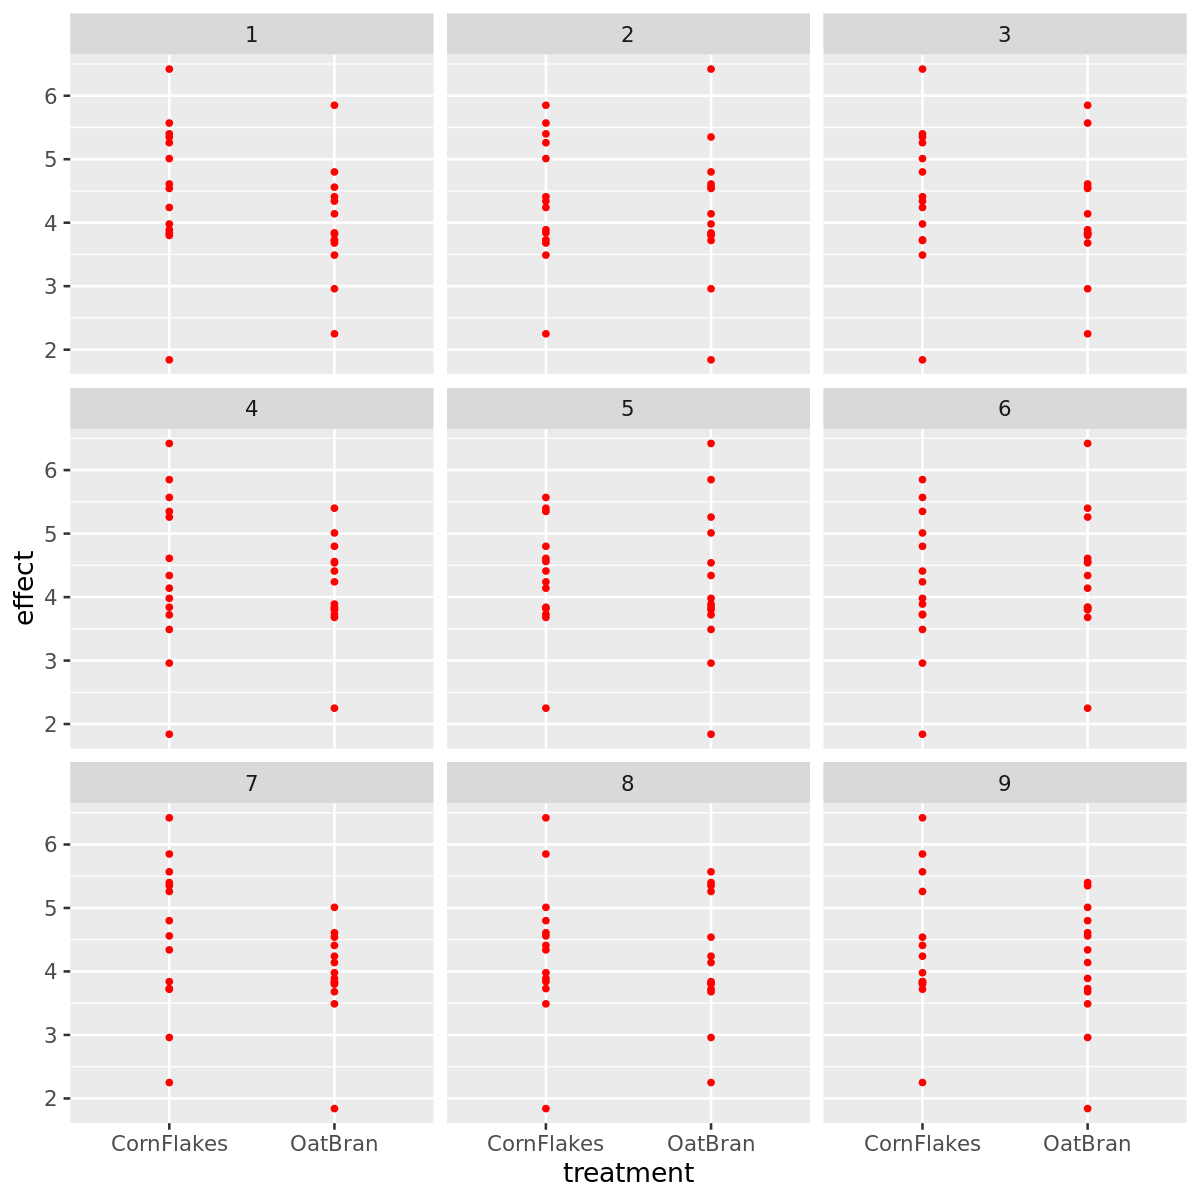

In [ ]:
# set plot dimensions
options(repr.plot.width=10, repr.plot.height=10)

permute %>% 
group_by(replicate) %>%
filter(replicate <= 9) %>% 
ggplot(aes(x=treatment, y=effect)) + 
  geom_point(color = "red") + 
  facet_wrap(~replicate) + 
  theme_grey(base_size=16)

We can see that the values of the 2 groups have been randomly mixed for each of the samples

#### 1.2. Generate a null distribution based on the test statistic

We can generate a null distribution based on the test statistic. Here, we `calculate` the _difference in means_ between the 2 groups for each of the permutations in the null hypothesis dataset to generate the `null distribution`

![infer_hypothesis_2.png](images/infer_hypothesis_2.png)

In [ ]:
resample <- permute %>%
            calculate(stat="diff in means", 
                      order=c("OatBran","CornFlakes")) # OatBran - CornFlakes

In [ ]:
head(resample)
tail(resample)

replicate,stat
<int>,<dbl>
1,-0.5828571
2,-0.1842857
3,-0.3314286
4,-0.2428571
5,-0.1042857
6,0.1185714


replicate,stat
<int>,<dbl>
995,-1.3257143
996,-0.5285714
997,-0.5685714
998,-0.3471429
999,0.4714286
1000,-0.1857143


#### 1.3. Use the null distribution of test statistic values to calculate the p-value

We can visualize the `null distribution` of test statistic values as a histogram and plot our `observed` difference of means (```obs_diff_means```) in relation to this null distribution
- ```visualize```: plots the histogram of the null distribution
- ```shade_p_value```: extension of ggplot geom to plot the observed statistic (```obs_stat```) and shade regions that are greater/lesser in the distribution (```direction``` is ```two_sided```)

![infer_hypothesis_3.png](images/infer_hypothesis_3.png)

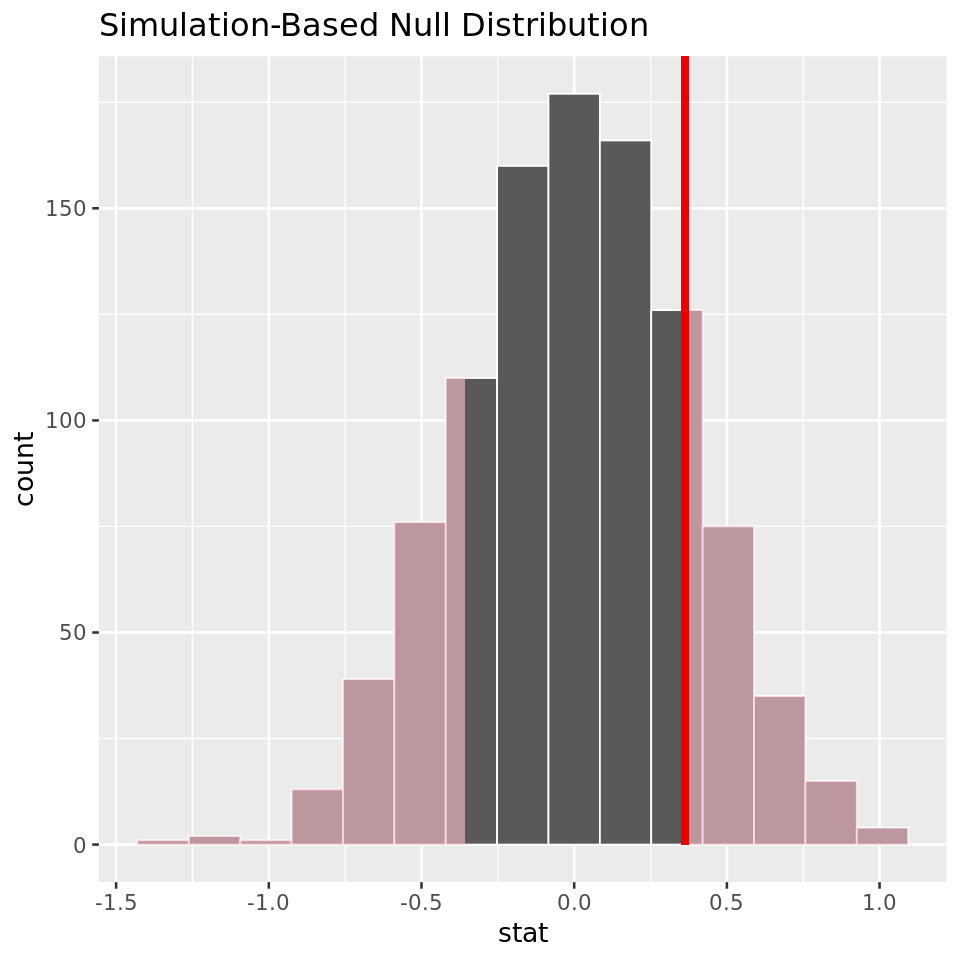

In [ ]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

resample %>% visualize + 
               shade_p_value(obs_stat = obs_diff_means, 
                             direction="two_sided") +
               theme_grey(base_size=16)

Finally, we can calculate the probability of observing the _difference of means_ between the 2 groups if there was **no difference** to begin with (i.e. the null hypothesis dataset)
- We use the ```get_p_value``` function and indicate that we want to find probability of the shade areas on both sides using ```direction="two_sided"```
- What this means is that we want to know the probability that the difference of mean is greater or equal to the observed difference in means regardless of the order of comparison (```OatBran - Cornflakes``` or ```Cornflakes - OatBran```)

In [ ]:
resample %>% get_p_value(obs_stat = obs_diff_means, 
                         direction="two_sided")

p_value
<dbl>
0.338


We can see that in the null distribution, ~35% of the time we can observe values that are **equal or greater** than those differences observed in the data. This implies that the observed difference between the 2 treatments is more likely to be consistent with the null hypothesis

---
### 2. Analytical approach using parametric theoretical distribution

![hypothesis_approach_parametric.png](images/hypothesis_approach_parametric.png)

In the analytical approach, the null distribution is not derived from resampling, but it is calculated from theoretical formulas of different types of distributions, each based on a standardized test statistic

- Each type of distribution is determined  by different parameters (hence called **parametric**) that obtained from the data (e.g. mean, variance, number of samples/groups)
- To calculate the probability of a summary statistic of a sample (e.g difference of means)  being observed in a standardized null distribution, a _test-statistic_ is needed to transform it into a standardized score for comparison

  - $Z=\frac{x-\mu}{\sigma / \sqrt{n}}$ for normal distribution

  - $t=\frac{\bar{x}-\mu}{s / \sqrt{\mathit{df}}}$ for t-distribution
  
  - $F=\frac{\text { Variance } 1}{\text { Variance } 2}$ for F-distribution
 
  - $\chi^{2}=\sum \frac{\left(\mathit{Observed}-\mathit{Expected}\right)^{2}}{\mathit{Expected}}$ for chi-square distribution

- They allow one to calculate the probability of an observed _test-statistic_ exceeding a theoretical null distribution (i.e. p-value) 

$$P(\text{Data}|\text{Null distribution})$$


---
### 3. Rank-based approach

The analytic approach based on theoretical distributions specified by parameters from the data assumes a **normal** distribution of the data

Consequently, this parametric approach may not work well under certain situations
- small and/or skewed data that are not normally distributed
- data that are ordinal in nature (e.g. pain score, ranking of food preferences)



In these cases, a rank-based approach can be used

- The values in the data are sorted and converted to ranks
- A rank-based test statistic is calculated to estimate the difference in ranks between the groups
- The test statistic is compared to a null distribution (through resampling or theoretical) to determine the _p-value_

![hypothesis_approach_rank.png](images/hypothesis_approach_rank.png)


---
## Interpretation of the p-value (significance testing)
In the Fisher formulation, the _p-value_ can be interpreted as the probability of observing the data given that there was no underlying difference i.e the amount of "surprise" in seeing such a difference  

$$P\left(\text{Observed data} | \text{Null distribution}\right)$$

- A low _p-value_ only tells us that the data is unlikely to be consistent with the hypothesis that there is no underlying difference, but it does not prove that there is a real difference
- A high _p-value_ tells us that the data is consistent with the null hypothesis that there is no underlying difference, but it does not prove it

A threshold of p=0.05 (1 out of 20) was chosen as a convention of what one could consider evidence for rejecting the null hypothesis. For a historical perspective, see: http://biostat.mc.vanderbilt.edu/wiki/pub/Main/ClinStat/EndOfSignificance.pdf
 
 ![p-value.png](images/p-value.png) 
 
From: http://www.jeremy-oakley.staff.shef.ac.uk/mas113/notes/hypothesis-testing-a-level-recap.html#fishers-p-value-method
 
This approach is typically used in **exploratory** studies

---

## Cautionary note about p-values

_p-values_ are prone to over-interpretation and we will explore a few cases
1. _p-values_ are affected by the sample size
2. Multiple testing to look for 'significant' _p-values_ on the same dataset can lead to spurious conclusions
3. _p-values_ do not say anything about the magnitude of any observed difference

We'll illustrate these cases by simulating populations with large, small and no differences, then calculate the p-values to see how they behave under different scenerios. To do this, we define some functions to help us simulate and calculate the p-values

In [ ]:
# Function to simulate 2 populations with defined mean and sd values
pop_simulate <- function(pop_size, mean_1, sd_1, mean_2, sd_2) {
    
    pop_1 <- rnorm(pop_size, mean = mean_1, sd = sd_1)
    pop_2 <- rnorm(pop_size, mean = mean_2, sd = sd_2)

    pop_mix <- tibble(pop_1 = pop_1, pop_2 = pop_2) %>% 
                pivot_longer(cols=c("pop_1","pop_2"), 
                             names_to = "group", 
                             values_to = "glucose") %>%
                mutate(group = as.factor(group))

    return(pop_mix)

}

# Function to repeatedly sample from the population and calculate the p-values using the t-test
sample_p <- function(replicate_n, sample_size, pop, threshold=0.05) {
    
    repeat_p <- replicate(replicate_n,
                pop %>% 
                group_by(group) %>% 
                sample_n(sample_size) %>% 
                ungroup %>%
                rstatix::t_test(glucose ~ group) %>%
                pull(p)
                )
    
    return(tibble(rep=seq(1,replicate_n), 
                  p=repeat_p, sig=if_else(repeat_p <= threshold, "yes","no")))
}

### 1. p-values are affected by sample size

Let us see how _p-values_ can change when we increase the sample size. 
- We simulate 2 different groups with different mean glucose values
- We use a statistical test to compare the 2 groups and calculate the _p-values_ when different sample sizes are used

First, we simulate 2 groups of 10,000 individuals each with different mean blood glucose levels

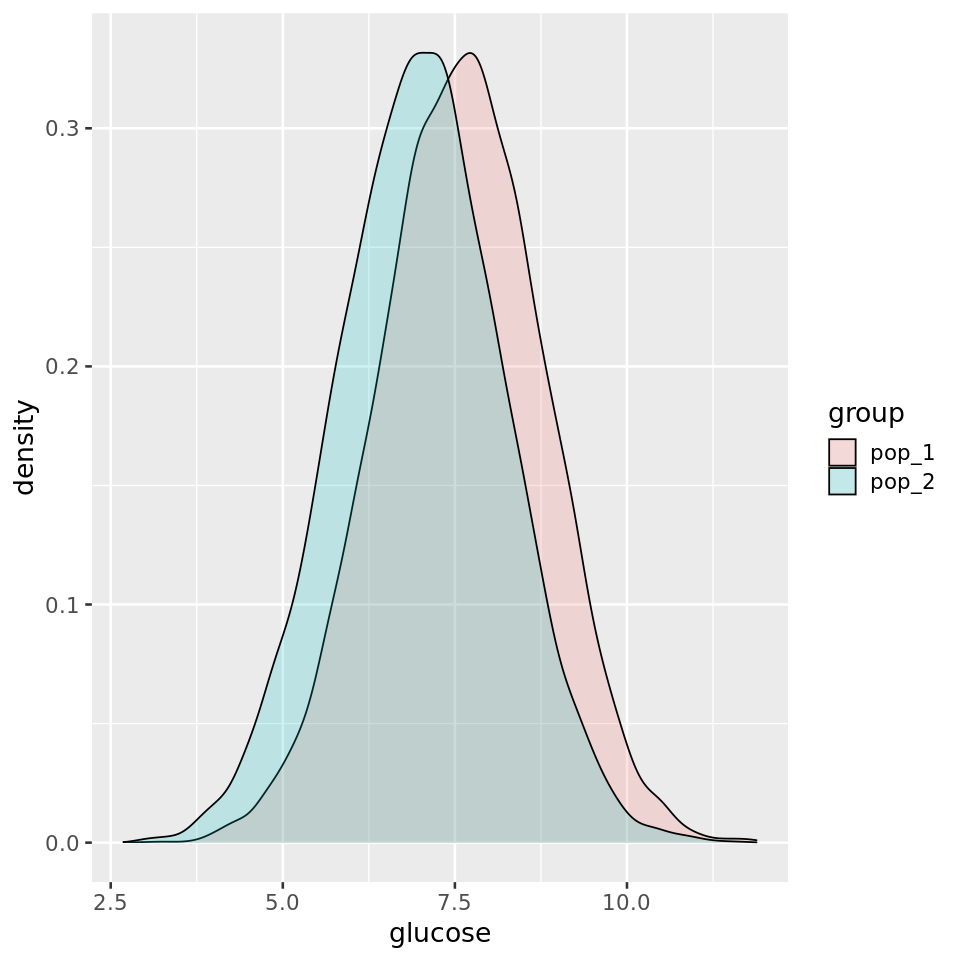

In [ ]:
# Simulate 2 different groups of 10,000 individuals with different mean glucose measurements
pop_diff <- pop_simulate(pop_size = 10000,
                         mean_1 = 7.6, sd_1 = 1.2,
                         mean_2 = 7.0, sd_2 = 1.2)

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

pop_diff %>% ggplot(aes(x=glucose, fill=group)) + 
               geom_density(alpha=0.2) +
               theme_gray(base_size = 16)

We can use a statistical test to compare the means of 2 groups using a sample size of 5 people to obtain a p-value and repeat the test 10 times

We plot the p-value for each repeat test and see if any of them cross the conventional threshold of 0.05

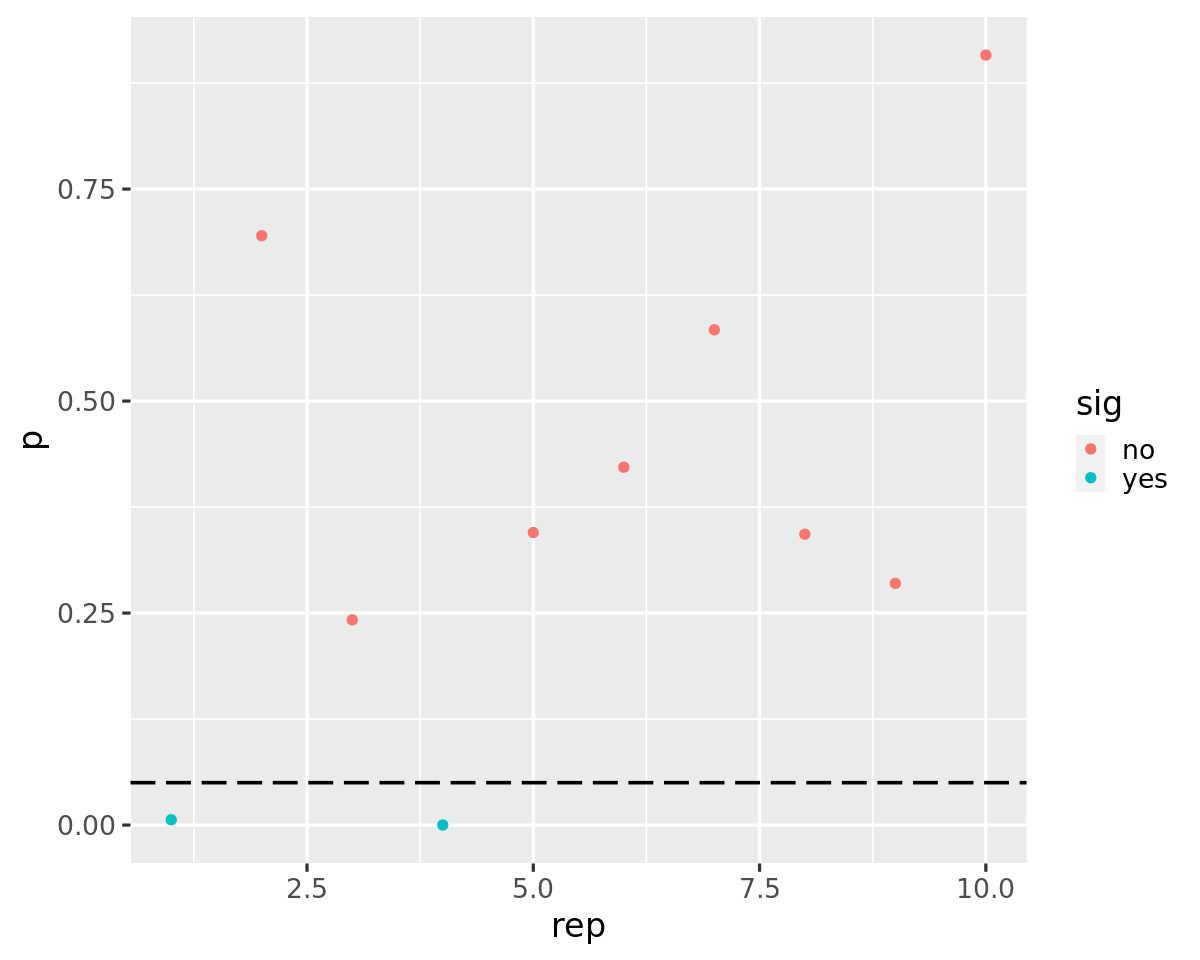

In [ ]:
# set plot dimensions
options(repr.plot.width=10, repr.plot.height=8)

sample_p(replicate_n = 10,sample_size = 5,pop_diff) %>% 
ggplot(aes(x=rep, y=p, color=sig)) + 
     geom_point(size=2.5) +
     geom_hline(yintercept = 0.05,linetype = 'longdash', col = 'black', size=1) +
     theme_grey(base_size = 20)

We see that few (if any) reach the threshold of 0.05 if the sample size is small even though there is a difference in the populations

We will now increase the samples size to `50`

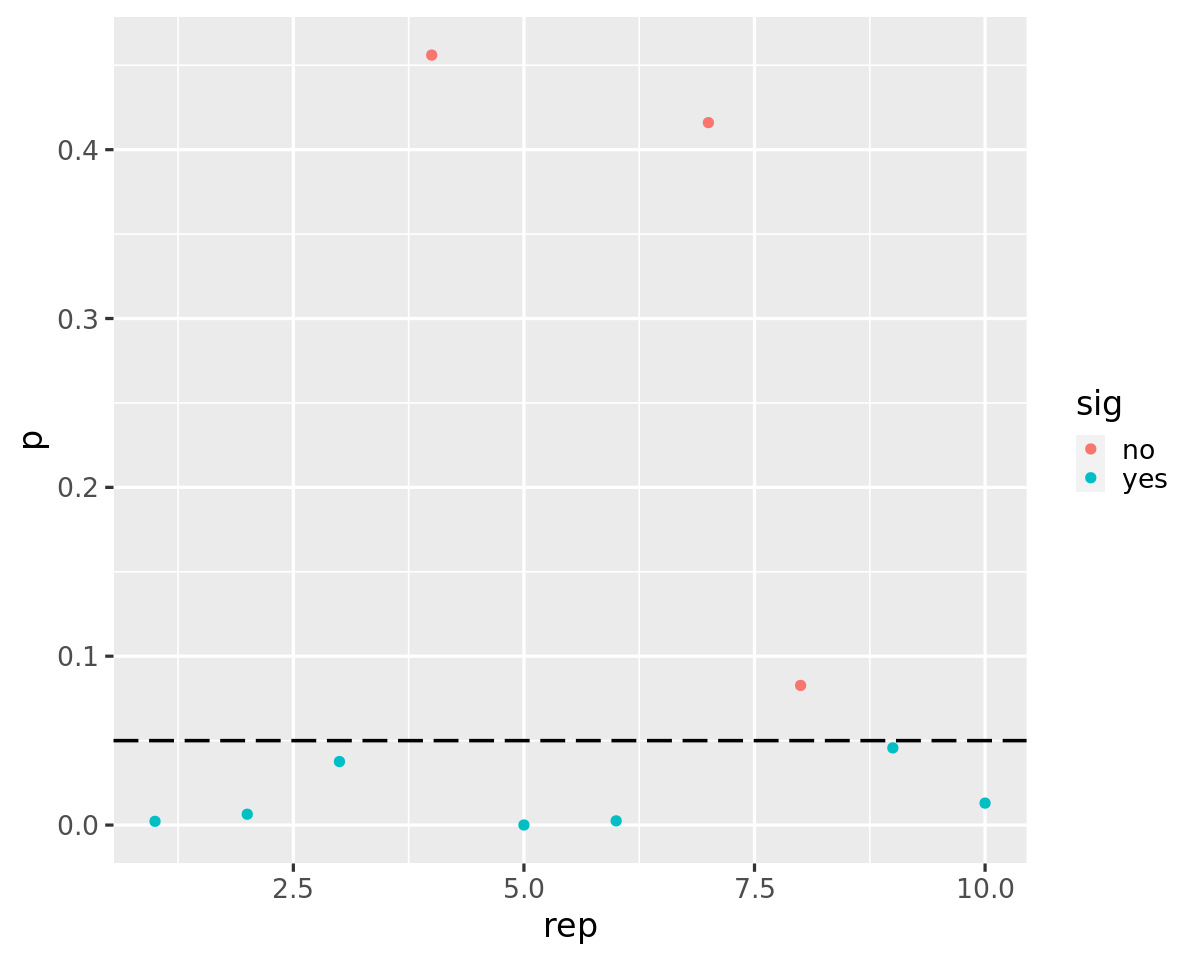

In [ ]:
# adjust size of the image output
options(repr.plot.width=10, repr.plot.height=8)

sample_p(replicate_n = 10,sample_size = 50,pop_diff) %>% 
ggplot(aes(x=rep, y=p, color=sig)) + 
     geom_point(size=2.5) +
     geom_hline(yintercept = 0.05,linetype = 'longdash', col = 'black', size=1) +
     theme_grey(base_size = 20)

Here we see that increasing the sample size increases the chance of finding a small p-value that is equal or smaller than the 0.05 threshold

### 2. Repeating a hypothesis test on a same sample can lead to spurious conclusions

In large datasets with multiple parameters, it is easy to perform multiple tests on the same dataset. Let us see what happens when repeat tests are performed on the same sample
- We simulate different groups with the same mean glucose measurements i.e. there is no difference
- We repeat statistical tests on the *same* dataset and see how the _p-values_ change

First, we simulate 2 groups of 1,000 individuals who have the same mean blood glucose levels

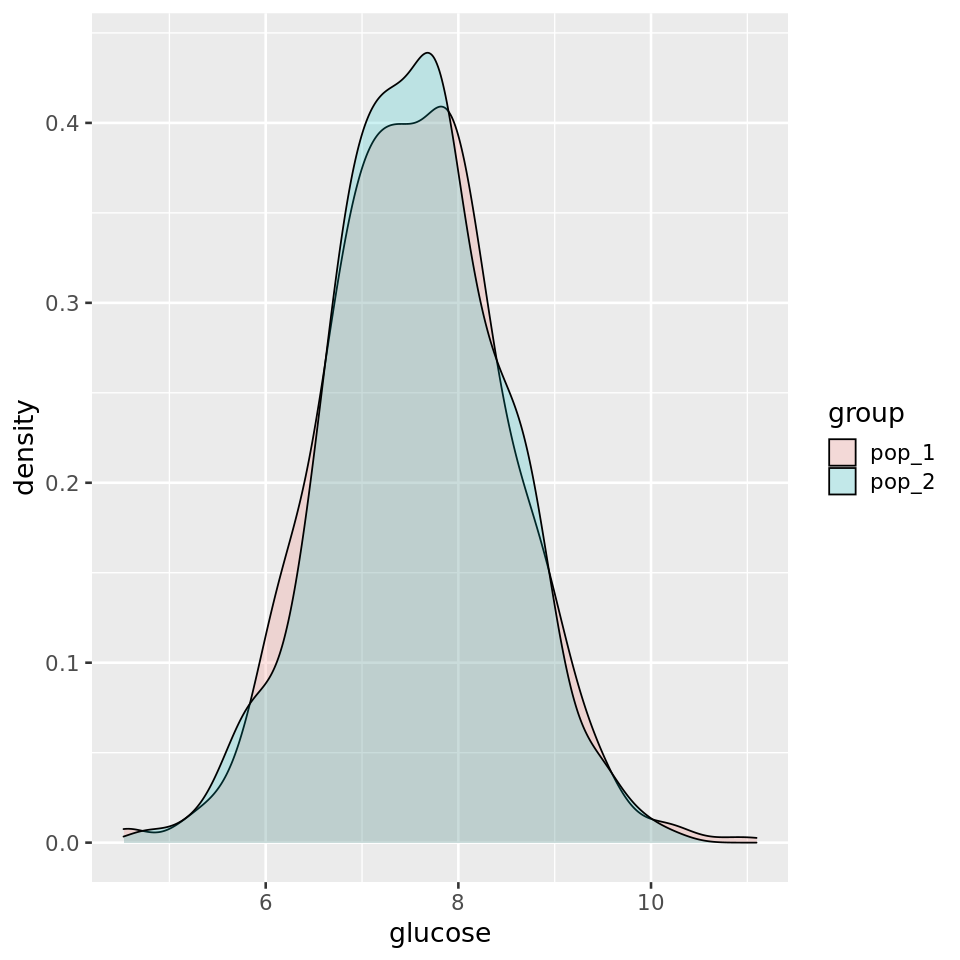

In [ ]:
# Simulate a sample of individuals with same mean glucose measurements
sample_same <- pop_simulate(pop_size = 1000,
                            mean_1 = 7.6, sd_1 = 0.9,
                            mean_2 = 7.6, sd_2 = 0.9)

# adjust size of the image output
options(repr.plot.width=8, repr.plot.height=8)

sample_same %>% 
ggplot(aes(x=glucose, fill=group)) + 
  geom_density(alpha=0.2) +
  theme_gray(base_size = 16)

We can use a statistical test to compare the means of 2 groups using a sample size of 5 people to obtain a p-value and repeat the test 5 times

We plot the p-value for each repeat test and see if any of them cross the conventional threshold of 0.05

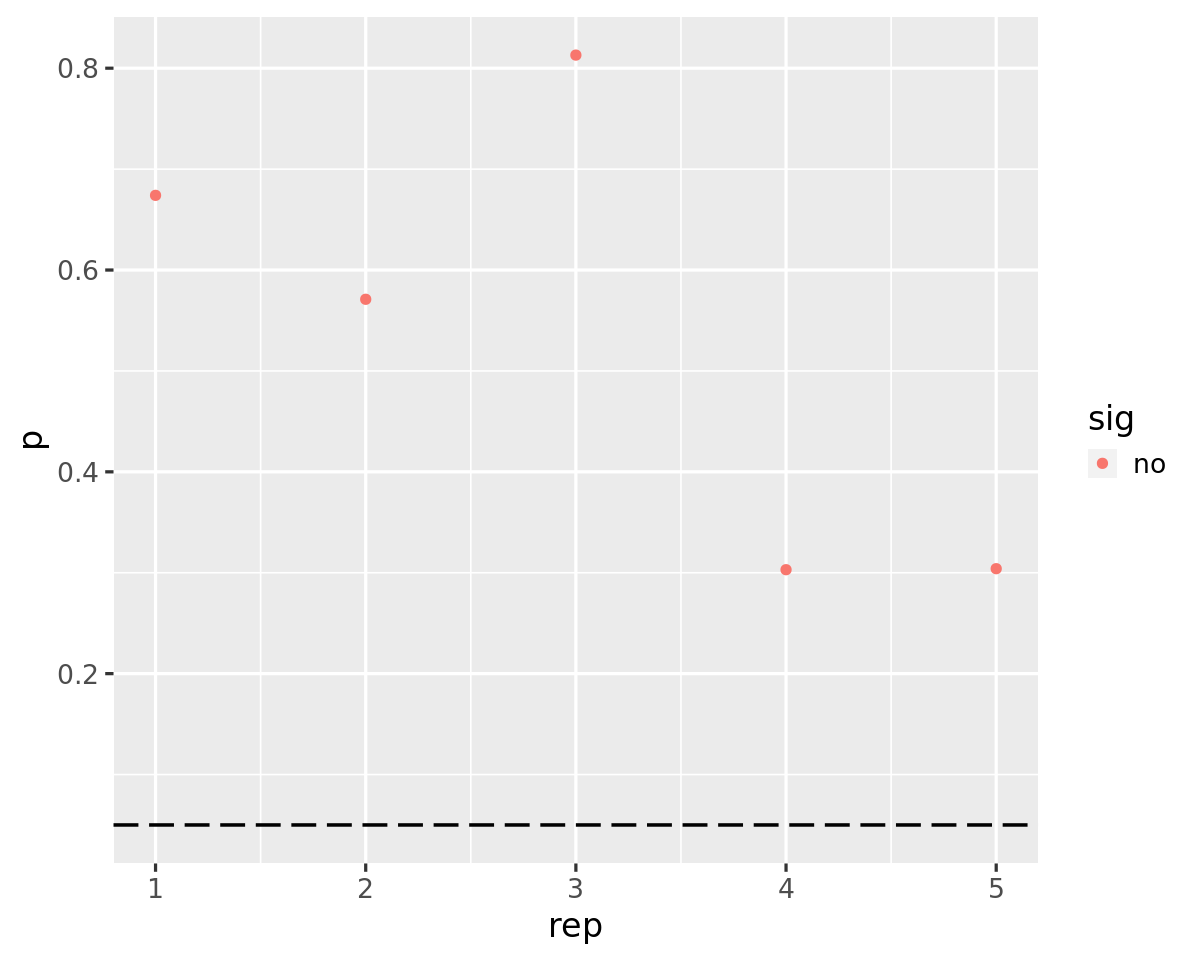

In [ ]:
# adjust size of the image output
options(repr.plot.width=10, repr.plot.height=8)

sample_p(replicate_n = 5,sample_size = 10,sample_same) %>% 
ggplot(aes(x=rep, y=p, color=sig)) + 
     geom_point(size=2.5) +
     geom_hline(yintercept = 0.05,linetype = 'longdash', col = 'black', size=1) +
     theme_grey(base_size = 20)

We note that the chance of finding a low p-value is small when the number of retests is low

We will now retest the sample 100 times

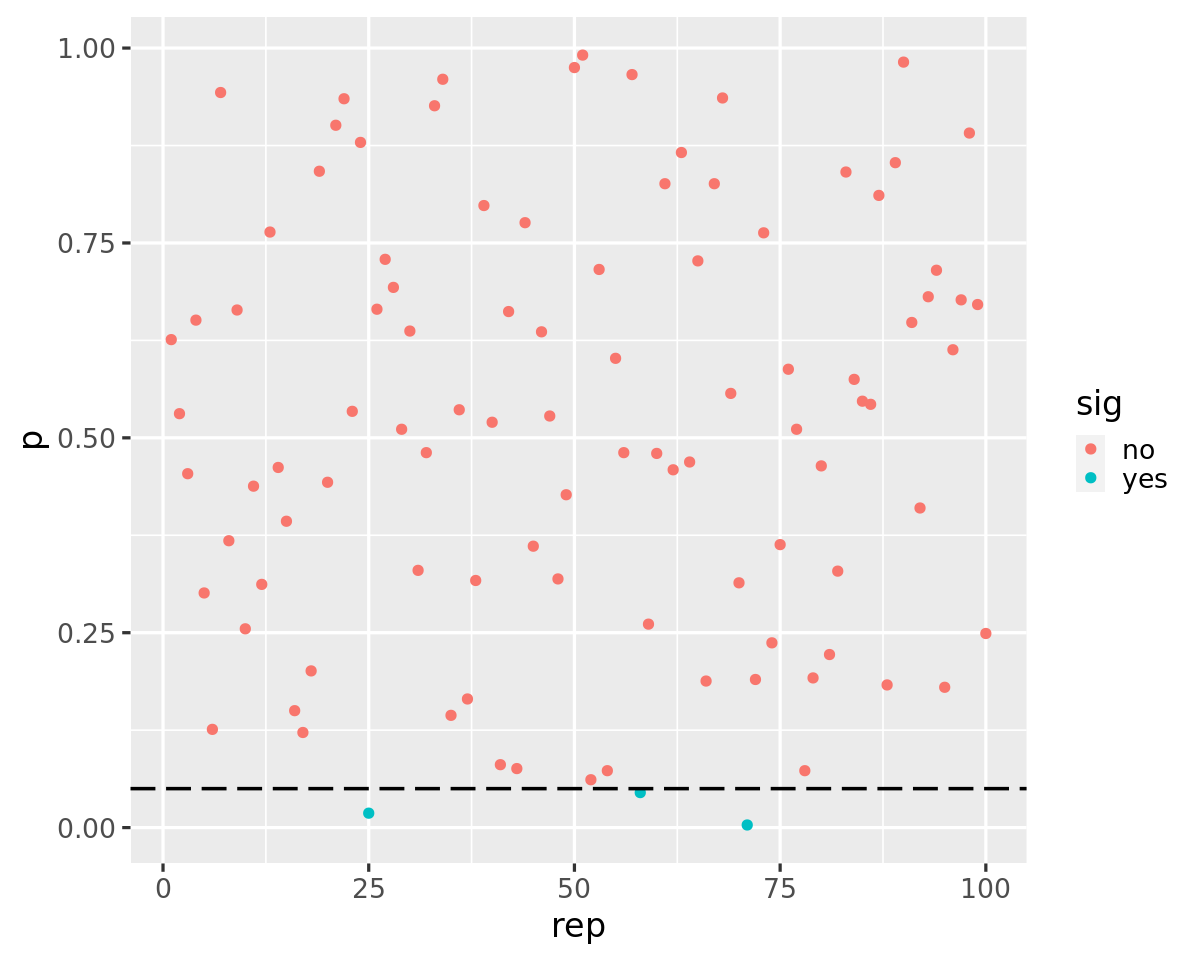

In [ ]:
# adjust size of the image output
options(repr.plot.width=10, repr.plot.height=8)

sample_p(replicate_n = 100,sample_size = 10,sample_same) %>% 
ggplot(aes(x=rep, y=p, color=sig)) + 
     geom_point(size=2.5) +
     geom_hline(yintercept = 0.05,linetype = 'longdash', col = 'black', size=1) +
     theme_grey(base_size = 20)

Increasing the number of retests on the same sample increases the chance of getting a low p-value that could be called significant (nominally <0.05), even though there is no difference in the 2 populations

![hypothesis_multiple_simple.png](images/hypothesis_multiple_simple.png)

### 3. A small p-value does not mean the observed effect is large

A small _p-value_ indicates that the data is less likely to  to be due to random chance, assuming there is no underlying difference in the population. It does **not** say anything about the magnitude of the difference.
- We simulate 2 populations with very small differences in the mean glucose levels
- We then calculate the _p-value_ from a different sample size and observe if we can obtain small _p-values_

First, we simulate 2 groups of 10,000 individuals who have small differences mean blood glucose levels

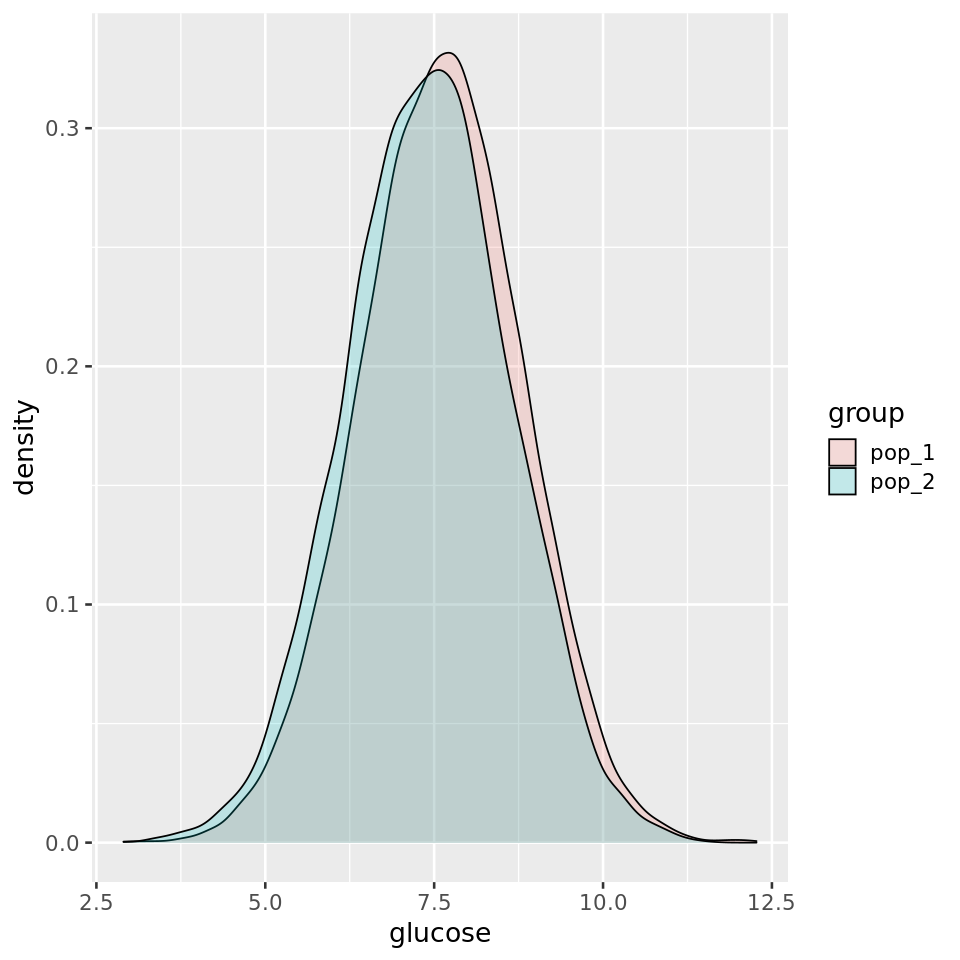

In [ ]:
# simulate 2 groups 10,000 people with small differences
pop_diff_small <- pop_simulate(pop_size = 10000,
                         mean_1 = 7.6, sd_1 = 1.2,
                         mean_2 = 7.4, sd_2 = 1.2)

# adjust size of the image output
options(repr.plot.width=8, repr.plot.height=8)

pop_diff_small %>% ggplot(aes(x=glucose, fill=group)) + 
               geom_density(alpha=0.2) +
               theme_gray(base_size = 16)

We use a statistical test to compare the 2 groups using a large sample size of 1,000

In [ ]:
sample_p(replicate_n = 1,
         sample_size = 1000,
         pop_diff_small)

rep,p,sig
<int>,<dbl>,<chr>
1,2.27e-05,yes


When the sample size is relatively large, we can see that even though the difference is very small, the _p-value_ can very small

---
## Neyman-Pearson paradigm (hypothesis testing)
As _p-value_ can be interpreted subjectively, later work by Neyman and Pearson established an different approach to extend Fisher's formulation by providing a framework for decision-making for **confirmatory** studies  
- Establishing criteria for decision-making and the required number of samples
- Deciding whether the null hypothesis should be accepted or rejected in favour of an alternative hypothesis

This framework involves an initial planning phase that considers the following to establish the critical value for the test-statistic
1. The minimum magnitude of difference **(effect size)** that may be expected for the alternative hypothesis
2. $\alpha$, the probability of a **false positive** (concluding there is a difference when there is none)
3. $\beta$, the probability of a **false negative** (concluding there is no difference when there is one)
4. The **power** to detect a difference, defined as $1 - \beta$
5. The **number of samples** required to fulfill the different criteria

![hypothesis_np.png](images/hypothesis_np.png)

In the analysis phase
- The test is performed and the **threshold** is used to decide the null hypothesis is accepted or rejected, based on the test statistic (not the _p-value_, but often used as a proxy)

Within the Neyman-Pearson decision framework, the $a$ threshold determines the **false positive** (Type I) error rate and the $\beta$ threshold determines the **false negative** (Type II) error rate

![hypothesis_error.png](images/hypothesis_error.png)

This framework is best suited for **repeated experiments** or sampling where one needs to control the type of errors in accepting/rejecting the null hypothesis.


## Null hypothesis significance testing (NHST) paradigm
The current framework that is used in biomedical researach (known as NHST) combines both (incompatible) approaches
- Setting up the null hypothesis and alternative hypothesis
- Deciding on the $\alpha$ threshold e.g. 0.05 (probability of a false positive in the long run)
- Performing the test and calculating the _p-value_ (probability of observing the data at hand assuming there is no underlying difference)
- Deciding on whether the test is significant based on whether the _p-value_ is smaller than $\alpha$

Notice that the comparison of the _p-value_ to the $\alpha$ threshold conflates two different concepts.
- The $\alpha$ sets the error rate of wrongly rejecting the null hypothesis in the long run
- The _p-value_ indicates the probability of observing the data assuming the null hypothesis

For example, if we calculate a _p-value_ of 0.05  and misinterpret it as $\alpha = 0.05$, we can wrongly conclude there is only a 5/100 chance of a false positive (wrongly rejecting the null hypothesis)

In the case of a 50/50 chance of a null hypothesis being true, a _p-value_ of 0.05 would correspond to a false positive rate of at least ~26%. For details see: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5750014/

![false_positive.png](images/false_positive.png)

The use of NHST and p-values remains controversial. For a review, see:  https://www.frontiersin.org/articles/10.3389/fpsyg.2015.00223/full

## Recommendations
- The effect sizes (magnitude of differences) should be emphasized with their confidence intervals. This allows one to judge the range and uncertainty in the effect sizes when comparing groups
- p-values should be interpreted as evidence against the null hypothesis (i.e. assuming there is no difference in the population) and not as a decision threshold
